# Event log enrichment 

In [213]:
### IMPORT ###
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


### LOCAL IMPORT ###
from config import config_reader

In [214]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
# print(yaml_config) # debug
log_dir = str(yaml_config["LOG_DIR"])
data_dir = str(yaml_config["DATA_DIR"]) # directory with survey and other data

# INPUT
log_file_name = "edu_event_log_PARA_raw_filtered_terziles-DEF-332-cases.csv" # Set the file name
field_notes = "field_notes.csv"

# FUNCTIONS

In [215]:
def count_backward_jumps(activities: list) -> int:
    """
    Counts the number of backward jumps in a list of activities for a given case.

    A backward jump occurs when an activity is revisited after it has already been encountered.
    This function iterates through a sequence of activities and counts each instance
    where an activity has been previously seen.

    Args:
        activities (List[str]): A list of activity names (strings) for a single case,
                                in chronological order.

    Returns:
        int: The total number of backward jumps within the provided sequence of activities.
    """
    seen_activities: Set[str] = set()
    backward_jumps: int = 0
    
    for activity in activities:
        if activity in seen_activities:
            backward_jumps += 1
        seen_activities.add(activity)
    
    return backward_jumps

In [216]:
def count_forward_jumps(activities: list) -> int:
    """
    Counts the number of forward jumps in a list of activities for a given case.

    A forward jump occurs when an activity is encountered for the first time 
    and it appears later in the sequence. This function iterates through a 
    sequence of activities and counts each instance where an activity has 
    not been previously seen and appears in a forward position.

    Args:
        activities (List[str]): A list of activity names (strings) for a single case,
                                in chronological order.

    Returns:
        int: The total number of forward jumps within the provided sequence of activities.
    """
    seen_activities: Set[str] = set()
    forward_jumps: int = 0

    for i, activity in enumerate(activities):
        # Check if the activity appears later in the sequence and hasn't been seen before
        if activity not in seen_activities and activity in activities[i+1:]:
            forward_jumps += 1
        # Mark the activity as seen
        seen_activities.add(activity)
    
    return forward_jumps

# MAIN

In [217]:
print(">> Setings")
print("Input event log file:", log_file_name)
path_log_file = Path(log_dir) /log_file_name 
print("Path file:", path_log_file)

>> Setings
Input event log file: edu_event_log_PARA_raw_filtered_terziles-DEF-332-cases.csv
Path file: data_log/edu_event_log_PARA_raw_filtered_terziles-DEF-332-cases.csv


In [218]:
print(">> Reading event log")
dic_t = {'Case ID':object, 'CaseLength':int, 'SUS_Tercile':int, 'Apprendimento percepito_Tercile':int, 'UEQ - Overall_Tercile':int} 
df_log_in = pd.read_csv(path_log_file, sep=",", dtype=dic_t) # initial event log
df_log = df_log_in.copy() # enriched event log

>> Reading event log


In [219]:
print(">> Removing columns from event log")
col_del_list = ['Variant', 'Variant index']
for col_del in col_del_list:
  if col_del in df_log.columns:
    print("Removig column:", col_del)
    df_log.drop(columns=col_del, inplace=True)

>> Removing columns from event log
Removig column: Variant
Removig column: Variant index


In [220]:
df_log.shape

(38245, 57)

In [221]:
print("Distinct cases in event log:", df_log["Case ID"].nunique())

Distinct cases in event log: 332


In [222]:
df_log.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,eventPara,click_num,...,UEQ - Hedonic,UEQ - Overall,TotalTimeHH,TotalTimeDD,CaseLength,Class,SUS_Tercile,Apprendimento percepito_Tercile,UEQ - Overall_Tercile,QuizAnswerCorrectRatioOverAll_Tercile
0,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,INTRO - INTRO_PageIN_0,2024-04-18 16:12:14.000,INTRO,menu_1,1,0,PageIN,INTRO_PageIN_0,0,...,-2.25,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN
1,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_PageIN_0,2024-04-18 16:12:19.000,FUNCT,menu_2,10,0,PageIN,FUNCT_PageIN_0,0,...,-2.25,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN
2,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseENT_1,2024-04-18 16:12:20.000,FUNCT,menu_2,10,1,MouseENT,FUNCT_MouseENT_1,0,...,-2.25,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN
3,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseOUT_1,2024-04-18 16:12:20.000,FUNCT,menu_2,10,1,MouseOUT,FUNCT_MouseOUT_1,0,...,-2.25,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN
4,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseIN_1,2024-04-18 16:12:21.000,FUNCT,menu_2,10,1,MouseIN,FUNCT_MouseIN_1,0,...,-2.25,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN


In [223]:
df_log.columns

Index(['Case ID', 'Activity', 'Complete Timestamp', 'pageTitle', 'menu',
       'pageOrder', 'pagePara', 'eventPage', 'eventPara', 'click_num',
       'dbclick_num', 'QuizSessionCount', 'QuizAnswerCorrectTotal',
       'QuizAnswerWrongTotal', 'QuizAnswerCorrectRatioOverCount',
       'QuizAnswerCorrectRatioOverAll', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5',
       'Q_6', 'Q_7', 'Q_8', 'Q_9', 'Q_10', 'Q_11', 'Q_12', 'Q_13', 'Q_14',
       'Q_15', 'Q_16', 'Q_17', 'Q_18', 'Q_19', 'Q_20', 'Q_21', 'Q_22', 'Q_23',
       'Q_24', 'Q_25', 'Q_26', 'Q_27', 'Q_28', 'SUS',
       'Apprendimento percepito', 'UEQ - Pragmatic', 'UEQ - Hedonic',
       'UEQ - Overall', 'TotalTimeHH', 'TotalTimeDD', 'CaseLength', 'Class',
       'SUS_Tercile', 'Apprendimento percepito_Tercile',
       'UEQ - Overall_Tercile', 'QuizAnswerCorrectRatioOverAll_Tercile'],
      dtype='object')

In [224]:
null_counts = df_log.isnull().sum()
null_counts

Case ID                                   0
Activity                                  0
Complete Timestamp                        0
pageTitle                                 0
menu                                      0
pageOrder                                 0
pagePara                                  0
eventPage                                 0
eventPara                                 0
click_num                                 0
dbclick_num                               0
QuizSessionCount                          0
QuizAnswerCorrectTotal                    0
QuizAnswerWrongTotal                      0
QuizAnswerCorrectRatioOverCount          90
QuizAnswerCorrectRatioOverAll            90
Q_1                                       0
Q_2                                       0
Q_3                                       0
Q_4                                       0
Q_5                                       0
Q_6                                       0
Q_7                             

## Merging event log with new features

### Class cardinality

In [225]:
print(">> Adding class cardinality")
df_log["Class"].unique()

>> Adding class cardinality


array(['SMTO3', 'SMTO2', 'SMTO1', 'SMCN1', 'SMCN2', 'ECO', 'SAA'],
      dtype=object)

In [226]:
# Calculate the count (numerosity) of each unique value in the "Class" column
distinct_class_counts = df_log[['Class', 'Case ID']].drop_duplicates().groupby('Class').size().to_dict()
distinct_class_counts

{'ECO': 124,
 'SAA': 97,
 'SMCN1': 17,
 'SMCN2': 26,
 'SMTO1': 27,
 'SMTO2': 22,
 'SMTO3': 19}

In [227]:
total_distinct_class_counts = sum(distinct_class_counts.values())
print("Total of class:", total_distinct_class_counts)

Total of class: 332


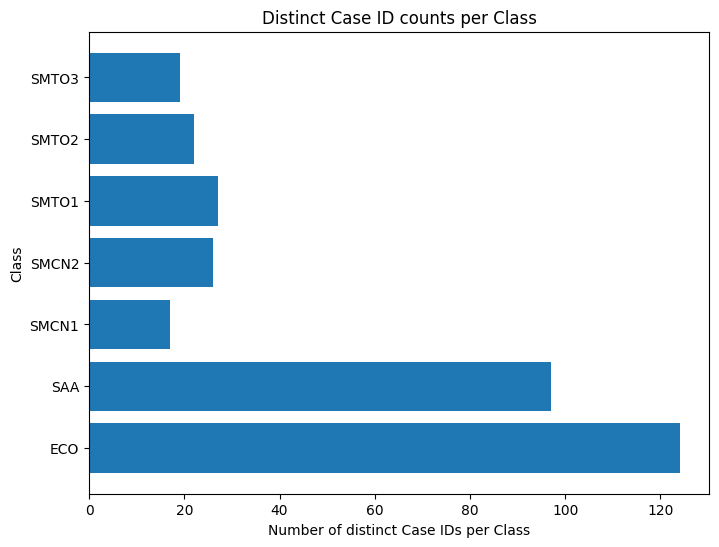

In [228]:
# Plotting a horizontal bar chart for the distinct class counts
plt.figure(figsize=(8, 6))
plt.barh(list(distinct_class_counts.keys()), list(distinct_class_counts.values()))
plt.xlabel("Number of distinct Case IDs per Class")
plt.ylabel("Class")
plt.title("Distinct Case ID counts per Class")
plt.show()

In [229]:
# Step 2: Map the calculated counts back to the df_log based on the "Class" values
df_log['Class_Count'] = df_log['Class'].map(distinct_class_counts)

In [230]:
df_log.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,eventPara,click_num,...,UEQ - Overall,TotalTimeHH,TotalTimeDD,CaseLength,Class,SUS_Tercile,Apprendimento percepito_Tercile,UEQ - Overall_Tercile,QuizAnswerCorrectRatioOverAll_Tercile,Class_Count
0,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,INTRO - INTRO_PageIN_0,2024-04-18 16:12:14.000,INTRO,menu_1,1,0,PageIN,INTRO_PageIN_0,0,...,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN,19
1,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_PageIN_0,2024-04-18 16:12:19.000,FUNCT,menu_2,10,0,PageIN,FUNCT_PageIN_0,0,...,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN,19
2,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseENT_1,2024-04-18 16:12:20.000,FUNCT,menu_2,10,1,MouseENT,FUNCT_MouseENT_1,0,...,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN,19
3,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseOUT_1,2024-04-18 16:12:20.000,FUNCT,menu_2,10,1,MouseOUT,FUNCT_MouseOUT_1,0,...,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN,19
4,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseIN_1,2024-04-18 16:12:21.000,FUNCT,menu_2,10,1,MouseIN,FUNCT_MouseIN_1,0,...,-2.625,0.04,0.0,14,SMTO3,1,1,1,NaN,19


### Field notes

In [231]:
print(">> Adding field notes")
path_notes = Path(data_dir) / field_notes
print("Path:", path_notes)
dic_t = {"Class":object, "FN_N":int, "FN_Q":int, "FN_A":int, "FN_C":int, "FN_I":int, "FN_CT":object}
df_notes = pd.read_csv(path_notes, sep=";", dtype=dic_t)

>> Adding field notes
Path: data/field_notes.csv


In [232]:
df_notes.head()

,Class,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT
0,SAA,1,1,0,1,1,FA
1,ECO,0,0,1,0,1,SA
2,SMTO1,1,1,0,1,1,M
3,SMTO2,0,0,0,0,0,L
4,SMTO3,1,0,0,0,1,FA


In [233]:
# Merge df_notes into df_log on 'Class', adding the columns from df_notes to df_log
df_log = df_log.merge(df_notes, on='Class', how='left')

In [234]:
df_log.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,eventPara,click_num,...,Apprendimento percepito_Tercile,UEQ - Overall_Tercile,QuizAnswerCorrectRatioOverAll_Tercile,Class_Count,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT
0,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,INTRO - INTRO_PageIN_0,2024-04-18 16:12:14.000,INTRO,menu_1,1,0,PageIN,INTRO_PageIN_0,0,...,1,1,NaN,19,1,0,0,0,1,FA
1,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_PageIN_0,2024-04-18 16:12:19.000,FUNCT,menu_2,10,0,PageIN,FUNCT_PageIN_0,0,...,1,1,NaN,19,1,0,0,0,1,FA
2,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseENT_1,2024-04-18 16:12:20.000,FUNCT,menu_2,10,1,MouseENT,FUNCT_MouseENT_1,0,...,1,1,NaN,19,1,0,0,0,1,FA
3,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseOUT_1,2024-04-18 16:12:20.000,FUNCT,menu_2,10,1,MouseOUT,FUNCT_MouseOUT_1,0,...,1,1,NaN,19,1,0,0,0,1,FA
4,9blnsTZGJ1Fuv5AOXQ376tvfzaeul9ImruA0jij80hqTbX...,FUNCT - FUNCT_MouseIN_1,2024-04-18 16:12:21.000,FUNCT,menu_2,10,1,MouseIN,FUNCT_MouseIN_1,0,...,1,1,NaN,19,1,0,0,0,1,FA


### Activity duration

In [235]:
# Convert the 'Complete Timestamp' column to datetime format for time calculations
df_log['Complete Timestamp'] = pd.to_datetime(df_log['Complete Timestamp'])

# Sort by 'Case ID' and 'Complete Timestamp' to ensure activities are in chronological order within each case
df_log = df_log.sort_values(by=['Case ID', 'Complete Timestamp'])

# Shift the 'Complete Timestamp' column within each 'Case ID' to get the timestamp of the next activity
df_log['Next_Timestamp'] = df_log.groupby('Case ID')['Complete Timestamp'].shift(-1)

# Calculate the time difference in seconds and minutes between the current activity and the next activity
df_log['Activity_Time_s'] = (df_log['Next_Timestamp'] - df_log['Complete Timestamp']).dt.total_seconds()
df_log['Activity_Time_m'] = df_log['Activity_Time_s'] / 60

# Fill NaN values with 0 for the last activity in each case (as there's no next activity to calculate a time difference)
df_log[['Activity_Time_s', 'Activity_Time_m']] = df_log[['Activity_Time_s', 'Activity_Time_m']].fillna(0)

# Round the 'Activity_Time_s' and 'Activity_Time_m' columns to two decimal places
df_log['Activity_Time_s'] = df_log['Activity_Time_s'].round(2)
df_log['Activity_Time_m'] = df_log['Activity_Time_m'].round(2)

# Drop the temporary 'Next_Timestamp' column as it's no longer needed
df_log = df_log.drop(columns=['Next_Timestamp'])

In [236]:
df_log.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,eventPara,click_num,...,QuizAnswerCorrectRatioOverAll_Tercile,Class_Count,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT,Activity_Time_s,Activity_Time_m
5195,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_PageIN_0,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,INTRO_PageIN_0,1,...,2.0,26,0,0,1,1,0,FA,2.0,0.03
5196,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_MouseOUT_1,2024-04-22 14:11:44,INTRO,menu_1,1,1,MouseOUT,INTRO_MouseOUT_1,1,...,2.0,26,0,0,1,1,0,FA,1.0,0.02
5197,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_MouseIN_1,2024-04-22 14:11:45,INTRO,menu_1,1,1,MouseIN,INTRO_MouseIN_1,1,...,2.0,26,0,0,1,1,0,FA,197.0,3.28
5198,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_MouseENT_1,2024-04-22 14:15:02,INTRO,menu_1,1,1,MouseENT,INTRO_MouseENT_1,1,...,2.0,26,0,0,1,1,0,FA,330.0,5.50
5199,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_PageOUT_0,2024-04-22 14:20:32,INTRO,menu_1,1,0,PageOUT,INTRO_PageOUT_0,1,...,2.0,26,0,0,1,1,0,FA,1.0,0.02


### Backward / Forward jumps

In [237]:
# Convert the 'Complete Timestamp' column to datetime format
df_log['Complete Timestamp'] = pd.to_datetime(df_log['Complete Timestamp'])

# Sort by 'Case ID' and 'Complete Timestamp' for chronological order within each case
df_log = df_log.sort_values(by=['Case ID', 'Complete Timestamp'])

# Apply the function to count backward jumps for each 'Case ID' and add the result as a new column
df_log['Backward_Jumps'] = df_log.groupby('Case ID')['Activity'].transform(count_backward_jumps)

# Apply the function to count forward jumps for each 'Case ID' and add the result as a new column
# df_log['Forward_Jumps'] = df_log.groupby('Case ID')['Activity'].transform(count_forward_jumps)

In [238]:
df_log.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,eventPara,click_num,...,Class_Count,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT,Activity_Time_s,Activity_Time_m,Backward_Jumps
5195,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_PageIN_0,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,INTRO_PageIN_0,1,...,26,0,0,1,1,0,FA,2.0,0.03,0
5196,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_MouseOUT_1,2024-04-22 14:11:44,INTRO,menu_1,1,1,MouseOUT,INTRO_MouseOUT_1,1,...,26,0,0,1,1,0,FA,1.0,0.02,0
5197,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_MouseIN_1,2024-04-22 14:11:45,INTRO,menu_1,1,1,MouseIN,INTRO_MouseIN_1,1,...,26,0,0,1,1,0,FA,197.0,3.28,0
5198,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_MouseENT_1,2024-04-22 14:15:02,INTRO,menu_1,1,1,MouseENT,INTRO_MouseENT_1,1,...,26,0,0,1,1,0,FA,330.0,5.50,0
5199,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO - INTRO_PageOUT_0,2024-04-22 14:20:32,INTRO,menu_1,1,0,PageOUT,INTRO_PageOUT_0,1,...,26,0,0,1,1,0,FA,1.0,0.02,0


## Saving event log enriched

In [239]:
print(">> Saving enriched event log")
log_file_name_enr = f"{Path(log_file_name).stem}_enr.csv"
path_log_file = Path(log_dir) / log_file_name_enr 
print("Path:", path_log_file)
df_log.to_csv(path_log_file, sep = ",", index=False)

>> Saving enriched event log
Path: data_log/edu_event_log_PARA_raw_filtered_terziles-DEF-332-cases_enr.csv
